<a href="https://colab.research.google.com/github/sdelta/Practical_DL/blob/spring21/homework03/diverging_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download dataset, install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/celeba_data

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [3]:
!mkdir celeba
!cp drive/MyDrive/celeba_data/* celeba
!cp -R drive/MyDrive/CelebA/Img/img_align_celeba.zip ./celeba

In [4]:
!ls celeba

identity_CelebA.txt   list_eval_partition.txt
img_align_celeba.zip  list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [5]:
!cd celeba && unzip -q img_align_celeba.zip && cd ..

In [6]:
!pip install pytorch-ignite sklearn optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 30.5 MB/s 
     |████████████████████████████████| 348 kB 80.7 MB/s 
     |████████████████████████████████| 81 kB 194 kB/s 
     |████████████████████████████████| 209 kB 91.8 MB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 112 kB 90.5 MB/s 
     |████████████████████████████████| 147 kB 94.4 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=551ce27bbd28631dd89ead6f88155f49c4d446b446b9372da6528f6ddf4fca48
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=17700baaf1ae1301c34c770bf65a9312c069d339a670fd807e748d8bec1a860d
  Stored in directory: /r

## Load data

In [7]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")


torch: 1.12.1+cu113
torchvision: 0.13.1+cu113
ignite: 0.4.10


In [8]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


In [9]:
ignite.utils.manual_seed(117)


In [10]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)


<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [11]:
from torchvision.datasets import ImageFolder

image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    transform=data_transform
)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))


In [12]:
batch_size = 128
TAGS_NUMBER = 40


train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2,
    pin_memory=True,
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2,
    pin_memory=True,
    shuffle=False, 
    drop_last=True,
)


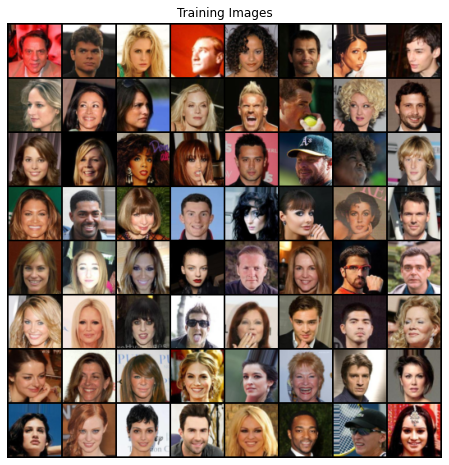

In [13]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [14]:
from collections import namedtuple

Hyperparams = namedtuple("Hyperparams", ["lr", "betas", "lambda_gp", "gamma", "max_epochs"])
NNState = namedtuple("NNState", ["netG", "netD", "optimizerG", "optimizerD"])

## Nets definition

In [15]:
from copy import copy
from typing import List, Optional
from collections import OrderedDict


class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)


class Noise(object):
    def __init__(self, shape:List[int], randomizer, idx:int):
        self.shape = shape
        self.randomizer = randomizer
        self.idx = idx

    def __call__(self):
        return self.randomizer._get_random(self.idx)


class AddScaledNoise(nn.Module):
    def __init__(self, shape:List[int], randomizer, idx:int):
        super(AddScaledNoise, self).__init__()
        self.shape = shape
        self.weight = nn.Parameter(torch.zeros(shape))
        self.randomizer = randomizer
        self.idx = idx

    def forward(self, input1):
        noise = self.randomizer._get_random(self.idx)
        assert list(input1.shape[1:]) == self.shape, "shape mismatch {} {}".format(input1.shape, self.shape)
        return input1 + self.weight.mul(noise)


class Randomizer(object):
    def __init__(self):
        self.register = []
        self.rnd = []

    def create_noise_layer(self, shape, subclass=None):
        layer = subclass(shape, self, len(self.register))
        self.register.append(layer)
        self.rnd.append(None)
        return layer

    def _get_random(self, idx):
        assert self.rnd[idx] is not None
        cur_rnd = self.rnd[idx]
        self.rnd[idx] = None
        return cur_rnd

    def set_rnd(self, rnd):
        self.rnd = copy(rnd)

    def generate_rnd(self, batch_size:int):
        result = []
        for layer in self.register:
            result.append(torch.randn([batch_size] + layer.shape, device=idist.device()))
        return result


class Generator(nn.Module):
    START_LATENT = 100
    def __init__(self):
        super(Generator, self).__init__()

        self.randomizer = Randomizer()

        self.initial = self.randomizer.create_noise_layer([self.START_LATENT], subclass=Noise)

        self.generator = nn.Sequential(OrderedDict([
            #('linear0', nn.Linear(self.START_LATENT + TAGS_NUMBER, self.START_LATENT + TAGS_NUMBER)),
            #('relu_0', nn.LeakyReLU()),
            ('linear', nn.Linear(self.START_LATENT + TAGS_NUMBER, 512 *8*8)),
            ('reshape', Reshape([-1, 512, 8, 8])),
            ('norm_1', nn.BatchNorm2d(512)),
            ('relu_1', nn.LeakyReLU()),

            ('conv_1', nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('add_noise_1', self.randomizer.create_noise_layer([512, 8, 8], subclass=AddScaledNoise)),
            ('norm_2', nn.BatchNorm2d(512)),
            ('relu_2', nn.LeakyReLU()),


            ('shuffle_2', nn.PixelShuffle(2)),
            ('conv_2', nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('add_noise_2', self.randomizer.create_noise_layer([128, 16, 16], subclass=AddScaledNoise)),
            ('norm_3', nn.BatchNorm2d(128)),
            ('relu_3', nn.LeakyReLU()),

            ('conv_3', nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('add_noise_3', self.randomizer.create_noise_layer([128, 16, 16], subclass=AddScaledNoise)),
            ('norm_4', nn.BatchNorm2d(128)),
            ('relu_4', nn.LeakyReLU()),

            ('shuffle_4', nn.PixelShuffle(2)),
            ('conv_4', nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('add_noise_4', self.randomizer.create_noise_layer([32, 32, 32], subclass=AddScaledNoise)),
            ('norm_5', nn.BatchNorm2d(32)),
            ('relu_5', nn.LeakyReLU()),

            ('conv_5', nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('add_noise_5', self.randomizer.create_noise_layer([32, 32, 32], subclass=AddScaledNoise)),
            ('norm_6', nn.BatchNorm2d(32)),
            ('relu_6', nn.LeakyReLU()),

            ('shuffle_6', nn.PixelShuffle(2)),
            ('conv_6', nn.Conv2d(8, 3, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('norm_7', nn.BatchNorm2d(3)),
            ('relu_7', nn.LeakyReLU()),


            ('conv_7', nn.Conv2d(3, 3, kernel_size=3, padding='same', padding_mode='reflect', bias=False)),
            ('norm_8', nn.BatchNorm2d(3)),
            ('tanh', nn.Tanh())
        ]))

    def forward(self, tags, rnd=None, batch_size:Optional[int]=None):
        if rnd is None:
            assert batch_size
            rnd = self.generate_rnd(batch_size)
        else:
            assert batch_size is None
        self.randomizer.set_rnd(rnd)
        init = self.initial()
        assert init.size(0) == tags.size(0), f"init_batch_size {init.size(0)} != tags_batch_size {tags.size(0)}"
        latent = torch.cat([init, tags], dim=1)
        return self.generator(latent)

    def generate_rnd(self, batch_size:int):
        return self.randomizer.generate_rnd(batch_size)

In [16]:
from collections import OrderedDict
from torch.nn.utils.parametrizations import spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('conv_1', spectral_norm(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False))),
            ('in_norm_1', nn.InstanceNorm2d(64)),
            ('relu_1', nn.LeakyReLU(0.2, inplace=True)),

            ('conv_2', spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False))),
            ('in_norm_2', nn.InstanceNorm2d(128)),
            ('relu_2', nn.LeakyReLU(0.2, inplace=True)),


            ('conv_3', spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False))),
            ('in_norm_3', nn.InstanceNorm2d(256)),
            ('relu_3', nn.LeakyReLU(0.2, inplace=True)),

            ('conv_4', spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, bias=False))),
            ('in_norm_4', nn.InstanceNorm2d(512)),
            ('relu_4', nn.LeakyReLU(0.2, inplace=True))    
        ]))

        self.head = nn.Sequential(OrderedDict([
            ('conv_5_final', spectral_norm(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=0)))
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('conv_final', spectral_norm(nn.Conv2d(in_channels=512, out_channels=TAGS_NUMBER, kernel_size=4, padding=0))),
            ('reshape_final', Reshape([-1, TAGS_NUMBER]))
        ]))

    def forward(self, x):
        embed = self.model(x)
        return self.head(embed), self.classifier(embed)


## Create & test nets and optimizers

In [17]:
def create_nets_state(hp:Hyperparams) -> NNState:
    netG = idist.auto_model(Generator())
    netD = idist.auto_model(Discriminator())
    optimizerG = idist.auto_optim(
        optim.Adam(netG.parameters(), lr=hp.lr, betas=hp.betas)
    )
    optimizerD = idist.auto_optim(
        optim.Adam(netD.parameters(), lr=hp.lr, betas=hp.betas)
    )
    return NNState(netG=netG, netD=netD, optimizerG=optimizerG, optimizerD=optimizerD)

In [18]:
def print_params(net, indent=0):
    for n, p in net.named_parameters():
        print(" " * indent, n)

def test_net_state(state: NNState):
    print("Generator named params:")
    print_params(state.netG)

    print("Generator result:")
    index = torch.randint(0, len(train_dataset), [1])[0]
    tags = train_dataset[index][1].view([1, -1]).to(idist.device())
    images = state.netG(tags=tags, batch_size=1)
    images = images.squeeze().data.cpu().permute(1, 2, 0).numpy()
    plt.imshow(images, interpolation="none")
    print()

    print("Discriminator summary")
    summary(state.netD, (3, 64, 64))
    print()

    print("Discriminator named params:")
    print_params(state.netD)

## Implement train & eval steps

In [19]:
from sklearn.metrics import roc_auc_score

def calc_roc_auc(real_scores, fake_scores):
    scores = np.concatenate((real_scores, fake_scores), axis=0)
    labels = [True] * real_scores.shape[0] + [False] * fake_scores.shape[0]
    return roc_auc_score(labels, scores)

def grad_penalty_loss(discriminator, real_data, fake_data, alpha=None):
    if alpha is None:
        alpha = torch.rand((real_data.size(0), 1, 1, 1), device=real_data.device)
    mixed_data = alpha * real_data + (1 - alpha) * fake_data
    mixed_data.requires_grad_(True)
    mixed_prediction = discriminator(mixed_data)[0]
    grads = torch.autograd.grad(
        inputs=mixed_data, 
        outputs=mixed_prediction, 
        create_graph=True, 
        retain_graph=True,
        grad_outputs=torch.ones_like(mixed_prediction)
    )[0]
    grads = grads.view(real_data.size(0), -1)
    return torch.mean((torch.linalg.norm(grads, dim=1) - 1) ** 2)

In [20]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [21]:
class TrainEvalFunctor(object):
    def __init__(self, hp:Hyperparams):
        self.hp = hp
        self.state = create_nets_state(hp)

    def train(self, engine, data):
        C_loss = nn.BCEWithLogitsLoss()

        # Set the models for training
        self.state.netG.train()
        self.state.netD.train()

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        self.state.netD.zero_grad()
        # Format batch
        real = data[0].to(idist.device())
        tags = data[1].to(idist.device()).to(torch.float32)
        b_size = real.size(0)
        # Forward pass real batch through D
        # Calculate loss on all-real batch
        result_D_real = self.state.netD(real)
        errD_real = -result_D_real[0]
        errC_real = C_loss(result_D_real[1], tags)
        # Calculate gradients for D in backward pass

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = self.state.netG.generate_rnd(b_size)
        # Generate fake image batch with G
        fake = self.state.netG(tags=tags, rnd=noise)
        # Calculate D's loss on the all-fake batch
        result_D_fake = self.state.netD(fake.detach())
        errD_fake = result_D_fake[0]
        # calc gradient penalty
        gp = self.hp.lambda_gp * grad_penalty_loss(self.state.netD, real, fake.detach())
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real.mean() + errD_fake.mean() + gp
        errC = errC_real
        total_D_loss = errD + self.hp.gamma * errC
        # Update D
        total_D_loss.backward()
        self.state.optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        self.state.netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # Calculate G's loss based on this output
        gen_result_D_fake = self.state.netD(fake)
        errG = -gen_result_D_fake[0].mean()
        errC_fake = C_loss(gen_result_D_fake[1], tags)
        total_G_loss = errG + self.hp.gamma * errC_fake
        # Calculate gradients for G
        total_G_loss.backward()
        # Update G
        self.state.optimizerG.step()

        roc_auc = calc_roc_auc(
            errD_real.squeeze().cpu().data.numpy(),
            errD_fake.squeeze().cpu().data.numpy(),
        )
        return {
            "Loss_G" : errG.item(),
            "Loss_D" : errD.item(),
            "Loss_C" : errC.item(),
            "Mean_real": errD_real.mean().item(),
            "Mean_fake": errD_fake.mean().item(),
            "gp_term": gp.item(),
            "roc_auc": roc_auc
        }

    def eval(self, engine, data):
        with torch.no_grad():
            self.state.netG.eval()
            tags = data[1].to(idist.device()).to(torch.float32)
            fake_batch = self.state.netG(tags=tags, batch_size=batch_size)
            fake = interpolate(fake_batch)
            real = interpolate(data[0])
            return fake, real

## Add Tensorboard logging

In [22]:
from ignite.contrib.handlers.tensorboard_logger import (
    global_step_from_engine,
    GradsHistHandler,
    GradsScalarHandler,
    TensorboardLogger,
    WeightsHistHandler,
    WeightsScalarHandler,
)

def define_tb_logging(
    trainer, evaluator, 
    state, log_dir
):
    tb_logger = TensorboardLogger(log_dir=log_dir)

    tb_logger.attach_output_handler(
        trainer,
        event_name=Events.ITERATION_COMPLETED(every=100),
        tag="training",
        output_transform=lambda l: l
    )

    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag="validation",
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )

    for tag, net, opt in [("Discr", state.netD, state.optimizerD), ("Gen", state.netG, state.optimizerG)]:
        tb_logger.attach_opt_params_handler(
            trainer,
            tag=tag,
            event_name=Events.ITERATION_COMPLETED(every=100), 
            optimizer=opt
        )

        tb_logger.attach(
            trainer,
            log_handler=WeightsScalarHandler(net, tag=tag),
            event_name=Events.ITERATION_COMPLETED(every=100),
        )

        tb_logger.attach(
            trainer,
            log_handler=WeightsHistHandler(net, tag=tag),
            event_name=Events.ITERATION_COMPLETED(every=100),
        )

        tb_logger.attach(
            trainer,
            log_handler=GradsScalarHandler(net, tag=tag), 
            event_name=Events.ITERATION_COMPLETED(every=100)
        )
    return tb_logger

## Training function and its helpers

In [23]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
def log_eval_results(fid_history, evaluator, trial, engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    fid_history.append(fid_score)
    print(f"Trial {trial} Epoch {engine.state.epoch} FID : {fid_score:4f}")

In [25]:
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import ProgressBar

def attach_metrics_bars(trainer, evaluator):
    RunningAverage(output_transform=lambda x: x["Mean_real"]).attach(trainer, "Mean_real")
    RunningAverage(output_transform=lambda x: x["Mean_fake"]).attach(trainer, "Mean_fake")
    RunningAverage(output_transform=lambda x: x["Loss_C"]).attach(trainer, "Loss_C")
    RunningAverage(output_transform=lambda x: x["gp_term"]).attach(trainer, "gp_term")
    RunningAverage(output_transform=lambda x: x["roc_auc"]).attach(trainer, "roc_auc")

    ProgressBar().attach(trainer, metric_names=['Loss_C', 'Mean_real','Mean_fake', 'roc_auc'])
    ProgressBar().attach(evaluator)

In [26]:
from ignite.handlers import Checkpoint


def get_checkpoint_handler(state:NNState, trainer, dir:str):
    to_save = state._asdict()
    score_function = lambda engine: -engine.state.metrics["fid"]
    return Checkpoint(
        to_save, dir,
        n_saved=1, filename_prefix='best',
        score_function=score_function,
        global_step_transform=global_step_from_engine(trainer)
    )


In [27]:
from functools import partial
from ignite.metrics import FID


LOG_DIR_PATTERN = "drive/MyDrive/gan_celeba_ac_logs/attempt_5"
CHECKPOINT_DIR = "drive/MyDrive/gan_celeba_ac_checkpoints_5"

def objective(trial):
    hp = Hyperparams(**{
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'betas': (0.5, 0.999),
        'lambda_gp': trial.suggest_float('lambda_gp', 1, 100, log=True),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'max_epochs': trial.suggest_float('max_epochs', 10, 30),
    })
    
    functor = TrainEvalFunctor(hp)

    functor.state.netG.apply(initialize_fn)
    functor.state.netD.apply(initialize_fn)

    #test_net_state(functor.state)

    trainer = Engine(functor.train)
    evaluator = Engine(functor.eval)

    fid_history = []
    FID(device=idist.device()).attach(evaluator, "fid")
    trainer.add_event_handler(Events.EPOCH_COMPLETED, partial(log_eval_results, fid_history, evaluator, trial.number))
    
    evaluator.add_event_handler(Events.COMPLETED, get_checkpoint_handler(functor.state, trainer, dir=CHECKPOINT_DIR))

    attach_metrics_bars(trainer, evaluator)

    log_dir = LOG_DIR_PATTERN.format(trial.number)
    tb_logger = define_tb_logging(trainer, evaluator, functor.state, log_dir=log_dir)
    
    trainer.run(train_dataloader, max_epochs=hp.max_epochs)

    tb_logger.close()

    return min(fid_history)

## Training

In [28]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [29]:
%tensorboard --logdir drive/MyDrive/gan_celeba_ac_logs

<IPython.core.display.Javascript object>

In [31]:
!nvidia-smi

Sun Nov 13 08:42:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    48W / 400W |   1360MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
import optuna

study = optuna.create_study(study_name="acw-gan")
study.enqueue_trial({"lr": 0.0002, "lambda_gp": 10, "max_epochs": 50, "gamma": 5})
study.optimize(objective, n_trials=1)

[I 2022-11-13 08:43:28,839] A new study created in memory with name: acw-gan
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:620: UserWarning: Fixed parameter 'gamma' with value 5 is out of range for distribution FloatDistribution(high=1.0, log=False, low=0.0, step=None).
  "for distribution {}.".format(name, param_value, distribution)
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:620: UserWarning: Fixed parameter 'max_epochs' with value 50 is out of range for distribution FloatDistribution(high=30.0, log=False, low=10.0, step=None).
  "for distribution {}.".format(name, param_value, distribution)


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 1 FID : 0.075885


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 2 FID : 0.048468


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 3 FID : 0.041388


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 4 FID : 0.027335


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 5 FID : 0.016819


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 6 FID : 0.021827


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 7 FID : 0.032395


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 8 FID : 0.017508


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 9 FID : 0.025942


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 10 FID : 0.016367


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 11 FID : 0.019520


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 12 FID : 0.012487


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 13 FID : 0.016414


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 14 FID : 0.022111


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 15 FID : 0.011979


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 16 FID : 0.014837


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 17 FID : 0.016901


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 18 FID : 0.010426


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 19 FID : 0.018627


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 20 FID : 0.014341


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 21 FID : 0.012220


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 22 FID : 0.014088


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 23 FID : 0.012331


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 24 FID : 0.008618


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 25 FID : 0.013693


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 26 FID : 0.011357


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 27 FID : 0.013923


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 28 FID : 0.020002


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 29 FID : 0.017618


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 30 FID : 0.012986


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 31 FID : 0.011268


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 32 FID : 0.010534


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 33 FID : 0.012692


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 34 FID : 0.009954


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 35 FID : 0.008654


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 36 FID : 0.009191


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 37 FID : 0.008187


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 38 FID : 0.008386


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 39 FID : 0.009762


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 40 FID : 0.010221


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 41 FID : 0.011002


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 42 FID : 0.012305


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 43 FID : 0.012777


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 44 FID : 0.010172


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 45 FID : 0.015081


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 46 FID : 0.010648


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 47 FID : 0.008791


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 48 FID : 0.009637


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Trial 0 Epoch 49 FID : 0.013523


[1/1271]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

[I 2022-11-13 10:44:33,518] Trial 0 finished with value: 0.008186648636875904 and parameters: {'lr': 0.0002, 'lambda_gp': 10, 'gamma': 5, 'max_epochs': 50}. Best is trial 0 with value: 0.008186648636875904.


Trial 0 Epoch 50 FID : 0.010205


## Post training analysis

In [34]:
state = torch.load(CHECKPOINT_DIR + "/best_checkpoint_37_-0.0082.pt", map_location=idist.device())

In [35]:
netG = Generator().to(idist.device())
netG.load_state_dict(state["netG"])




<All keys matched successfully>

In [36]:
tags = next(iter(test_dataloader))[1].to(idist.device())

In [37]:
img_list = netG(tags=tags, batch_size=128)

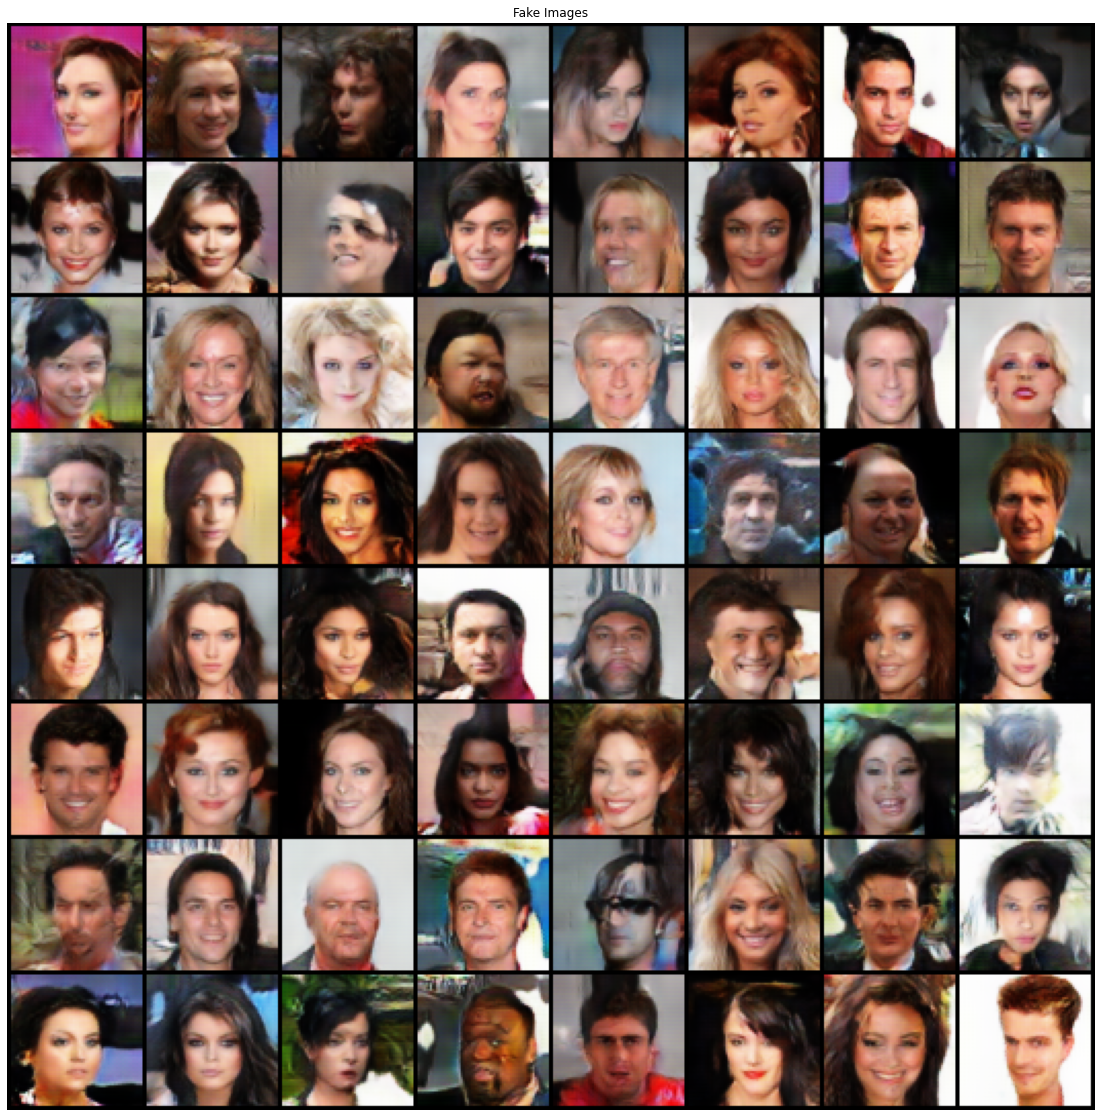

In [38]:


plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

## Conclusions

* normalization layers makes everything better
* Layer norm is worse than BatchNorm and InstanceNorm
* Final layers of D shouldn't be linear but convolutional
* There should be a lot of channels from the start
* Pay attention to layers with wgan-wp: they should have continious second derivative. Example of bad layer: ELU
* Bilinear upsample + conv after it is bad combo, it results in too much blur
* conv2dTranspose results into checkerboard artefacts
* hyperparameter tuning makes sense with many more epochs (I think at least 30-40)
* training for at least 20 epochs makes sense - achived best fid on last epoch (maybe try to train a bit more?)
* acw-gan-gp is a bit worse on 20 epochs than wgan-gp (0.02 vs 0.01 fid)

## Future work

### Infra
* checkpointing
* autodetect vanished gradient
* Monitor Number of statistically-different bins (NDB Score)
* use NDB for autodetect mode collapse
* ~~hyperparameters tuning~~

### StyleGan-1
Link https://paperswithcode.com/method/stylegan

Features:
1. ~~Separate noise for each scale~~
2. ~~Preprocess noise by scaling before adding~~
3. AdaIN blocks
4. Add Style with dense net preprocessing
5. Style mixing - using two style latents


### Progressive Gan
Link https://paperswithcode.com/method/progan


### Miscelanous
* Residual blocks
* Dropout in D
* Conditional GAN on labels
* R1 regularization https://paperswithcode.com/method/r1-regularization
* RAGAN
* SAGAN
* ~~Spectral normalization~~
* ~~AC-GAN~~

### Kaggle competition
There was a image generating comptition for 64x64 dog images about 3 years ago

write-ups of top solutions https://www.kaggle.com/c/generative-dog-images/discussion/106305

#### 1 place
https://www.kaggle.com/c/generative-dog-images/discussion/106324

・Model: BigGAN
- number of parameters G:10M, D:8M
- input noise from normal distribution (nz=120)
- use LeakyReLU
- attention on size 32 feature map
- use truncated trick (threshold=0.8)
- no EMA

・Loss: BCE loss
・Optimizer: Adam (lrG=3e-4, lrD=3e-4, beta1=0.0, beta2=0.999)
・Batch Size: 32
・Epochs: 130 (maximum kernel time limit, i.e. 32400sec)
・Others
- label smoothing 0.9 

At the beginning of this competition, I played with standard DCGANs, which got Public scores around 55. Then I used AC-GAN and got around 50. With ACGAN-projection, I could get around 39. Then I switched to BigGAN and jumped to around 31.

#### 2 place
https://www.kaggle.com/c/generative-dog-images/discussion/104211

Model: based on BigGAN
 * shared embedding of dog breed labels
 * hierarchical latent noise
 * projection
 * auxiliary classifier (ACGAN)

Loss: RaLS with weighted auxiliary classification loss

Batch size: 128

Exponential Moving Average of generator weights

Uniform input noise on real images

#### 3 place 
https://www.kaggle.com/c/generative-dog-images/discussion/106514

**losses**

I experimented with losses such as "standard-dcgan", "wgan-gp", "lsgan", "lsgan-with-sigmoid", "hinge", "relative-hinge". My experience is the best one for this problem with various models is the "standard dcgan" loss, the second best is "lsgan-with-sigmoid" loss.

**Attention at different stages**

According to the paper "Self-Attention Generative Adversarial Networks"(https://arxiv.org/pdf/1805.08318v2.pdf), self-attention at middle-to-high level feature maps achieve better performance because it receives more evidence and more freedom to choose conditions with larger feature maps. My experiences mostly concur with the paper findings. I have attention at 32x32 feature map for the generator, but at 16x16 feature map for the discriminator.

**Training settings**
The learning rate for the discriminator is 0.0004, and the learning rate for the generator is 0.0002;
batch size is 32(tried 64 but the result is not as stable as 32);
label smoothing; thanks the kernel https://www.kaggle.com/phoenix9032/gan-dogs-starter-24-jul-custom-layers and its author Nirjhar Roy.
learning rate scheduler: CosineAnnealingWarmRestarts
number of epoch: 170


#### The discussion after
Also a bit of results discussion afterward https://www.kaggle.com/competitions/generative-dog-images/discussion/106207


* SAGAN 
* SN in D and G both
* SN = more stable training but takes x2 epochs


